# Overview of Problem

For this competition, we are given 300 Monet images and 7038 photos. The goal is to build a model using the GAN achitecture that can accurately recreate Monet style images. Submissions are judged on MiFID (Memorization-informed Fréchet Inception Distance), where a smaller score means a more accurate image.

# Understand Data + Exploratory visualization

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model

import matplotlib.pyplot as plt
import numpy as np
import os

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

AUTOTUNE = tf.data.experimental.AUTOTUNE

2025-04-15 18:19:29.486684: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744741169.996323      55 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744741170.146315      55 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Number of replicas: 1


Data loading used from competition [example notebook](https://www.kaggle.com/code/amyjang/monet-cyclegan-tutorial)

In [2]:
monet_jpg_loc = '/kaggle/input/gan-getting-started/monet_jpg/'
monet_tfrec_loc = '/kaggle/input/gan-getting-started/monet_tfrec/'
photo_jpg_loc = '/kaggle/input/gan-getting-started/photo_jpg/'
photo_tfrec_loc = '/kaggle/input/gan-getting-started/photo_tfrec/'

In [3]:
MONET_FILENAMES = tf.io.gfile.glob(str(monet_tfrec_loc + '*.tfrec'))
print('Monet TFRecord Files:', len(MONET_FILENAMES))

PHOTO_FILENAMES = tf.io.gfile.glob(str(photo_tfrec_loc + '*.tfrec'))
print('Photo TFRecord Files:', len(PHOTO_FILENAMES))

Monet TFRecord Files: 5
Photo TFRecord Files: 20


In [4]:
IMAGE_SIZE = [256, 256]

def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

def read_tfrecord(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image

def load_dataset(filenames, labeled=True, ordered=False):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
    return dataset

In [5]:
BATCH_SIZE = 8

monet_ds = load_dataset(MONET_FILENAMES, labeled=True).cache().shuffle(300).batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)
photo_ds = load_dataset(PHOTO_FILENAMES, labeled=True).cache().shuffle(7038).batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

I0000 00:00:1744741194.272830      55 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1744741194.273555      55 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Now, lets look at a sample image

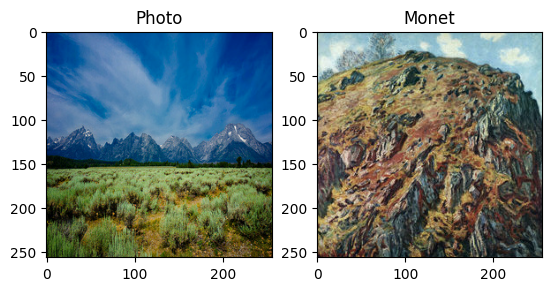

In [6]:
example_monet = next(iter(monet_ds))
example_photo = next(iter(photo_ds))
plt.subplot(121)
plt.title('Photo')
plt.imshow(example_photo[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Monet')
plt.imshow(example_monet[0] * 0.5 + 0.5)

After confirmming that the images conform to our expected dimensions, lets look at a larger sample.

In [7]:
def display_samples(ds, row, col):
    ds_iter = iter(ds)
    plt.figure(figsize=(15, int(15*row/col)))
    for j in range(row*col):
        example_sample = next(ds_iter)
        plt.subplot(row,col,j+1)
        plt.axis('off')
        plt.imshow(example_sample[0] * 0.5 + 0.5)
    plt.show()

**Photos**

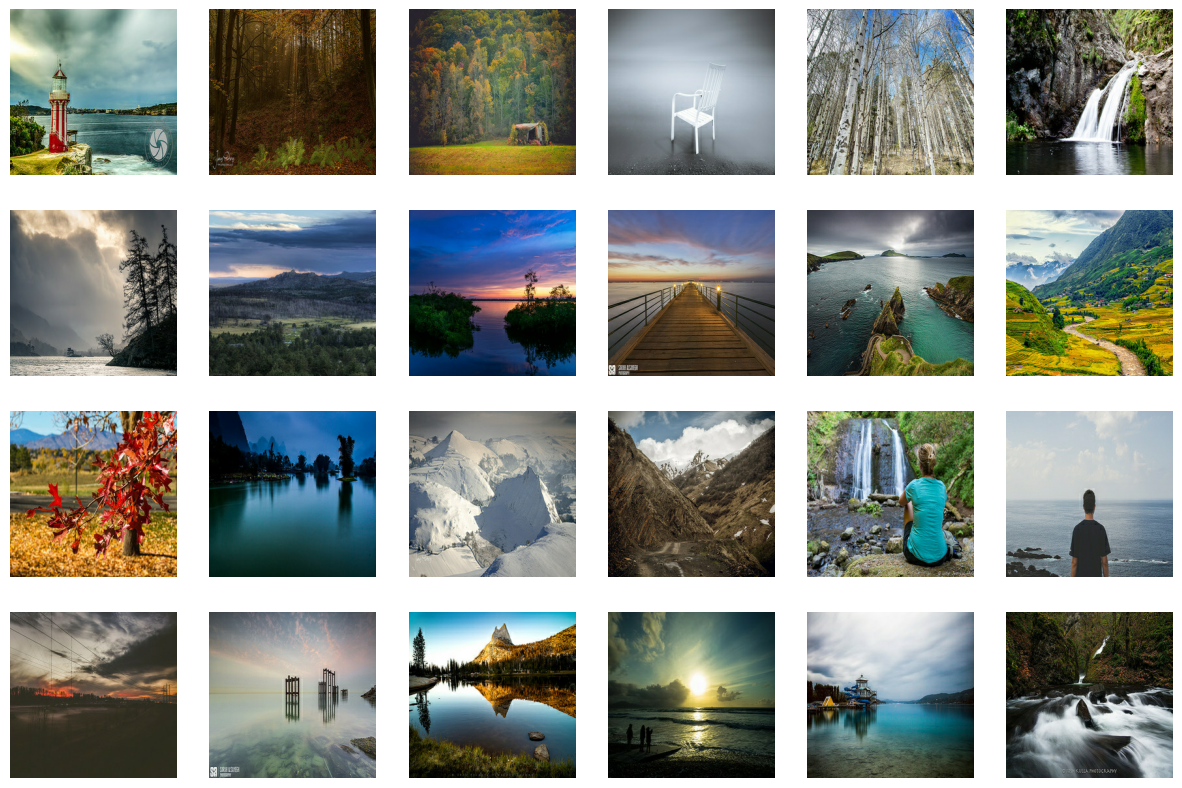

In [8]:
display_samples(photo_ds, 4, 6)

**Monet**

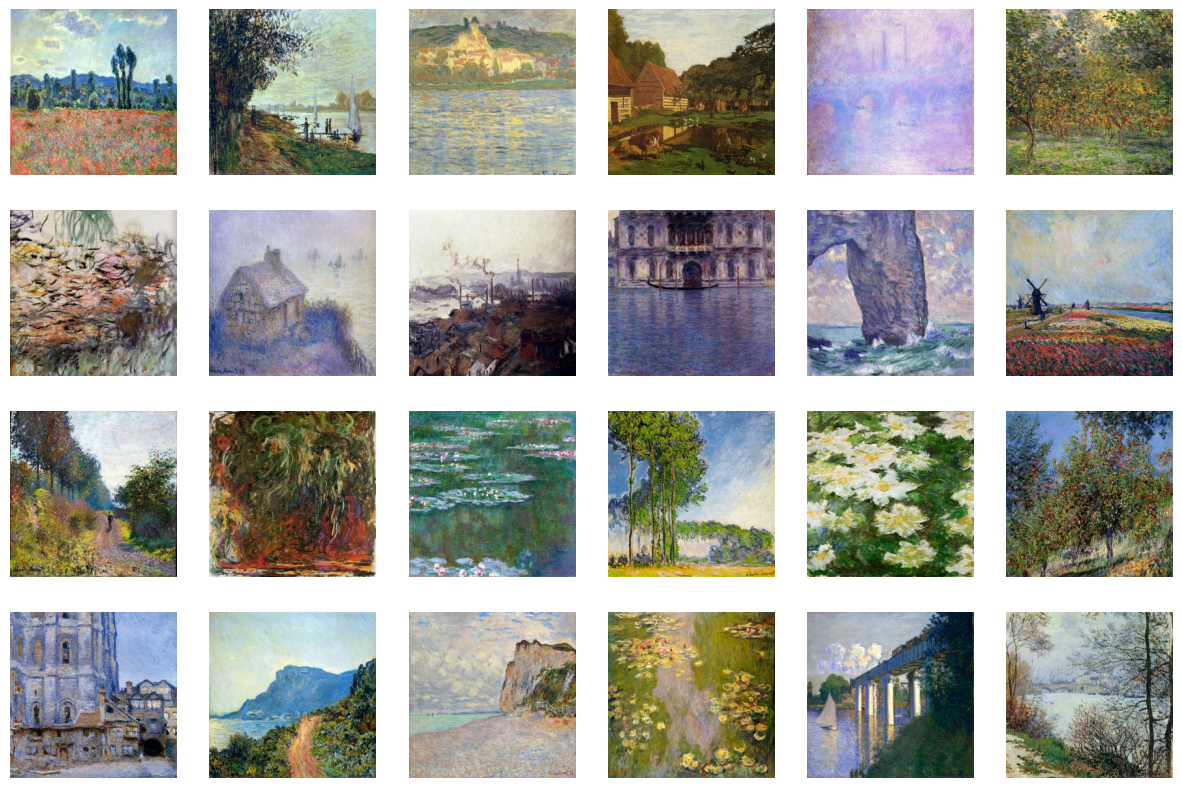

In [9]:
display_samples(monet_ds, 4, 6)

# Overview of Model Architecture 

For this competition, we have an unpaired image-to-image problem i.e. we don't have an exact training set of photo to Monet style. Instead we have a collection of Monet images and a separate collection of photos. To solve this, we will use a CycleGAN because it does not require paired images. We will use two generators and two descriminators for this model.

**CycleGAN**

A cycleGAN features two generators, one that transforms from the photo domain to the Monet domain, and a second that transforms from the Monet domain to the photo domain. Similarly, the model features two descriminators, one that determines real Monets from fake ones produced by generator one and a second descriminator that determines real photos from fake ones produced by the second generator.

The goal here is for an image to pass through the other domain and back while remaining as close to the original as possible.

First we will build the generators

In [10]:
def build_generator():
    inputs = layers.Input(shape=(*IMAGE_SIZE, 3))
    
    # Initial convolution
    x = layers.Conv2D(32, kernel_size=7, strides=1, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    
    # Downsampling
    x = layers.Conv2D(64, kernel_size=3, strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    
    x = layers.Conv2D(128, kernel_size=3, strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    
    # Residual Blocks
    for _ in range(3):
        x = residual_block(x, 128)
    
    # Upsampling
    x = layers.Conv2DTranspose(64, kernel_size=3, strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    
    x = layers.Conv2DTranspose(32, kernel_size=3, strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    
    # Output layer
    x = layers.Conv2D(3, kernel_size=7, strides=1, padding='same', activation='tanh')(x)
    
    return Model(inputs, x)

def residual_block(x, filters):
    init = x
    x = layers.Conv2D(filters, kernel_size=3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(filters, kernel_size=3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Add()([init, x])
    return x


In [11]:
generator_photo_to_monet = build_generator()
generator_monet_to_photo = build_generator()

Next we will build the Discriminators

In [12]:
def build_discriminator():
    inputs = layers.Input(shape=(*IMAGE_SIZE, 3))
    
    x = layers.Conv2D(32, kernel_size=4, strides=2, padding='same')(inputs)
    x = layers.LeakyReLU(0.2)(x)
    
    x = layers.Conv2D(64, kernel_size=4, strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(0.2)(x)
    
    # Classification layer
    x = layers.Conv2D(1, kernel_size=4, padding='same')(x)
    
    return Model(inputs, x)

In [13]:
discriminator_monet = build_discriminator()
discriminator_photo = build_discriminator()

**Specifying Loss Functions**

Lastly, we need to specify loss functions for our model. Here we will specify both discriminator and generator loss in addition to full cycle loss.

In [14]:
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real, generated):
    real_loss = loss_obj(tf.ones_like(real), real)
    generated_loss = loss_obj(tf.zeros_like(generated), generated)
    total_loss = real_loss + generated_loss
    return total_loss

def generator_loss(generated):
    return loss_obj(tf.ones_like(generated), generated)

In [15]:
def cycle_loss(real_image, cycled_image, LAMBDA):
    loss = tf.reduce_mean(tf.abs(real_image - cycled_image))
    return LAMBDA * loss

In [16]:
generator_photo_to_monet_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_monet_to_photo_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_monet_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_photo_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)


In [17]:
LAMBDA = 10  # Weight for cycle consistency loss

@tf.function
def train_step(photo, monet):
    with tf.GradientTape(persistent=True) as tape:
        # Forward cycle
        fake_monet = generator_photo_to_monet(photo, training=True)
        cycled_photo = generator_monet_to_photo(fake_monet, training=True)
        
        # Backward cycle
        fake_photo = generator_monet_to_photo(monet, training=True)
        cycled_monet = generator_photo_to_monet(fake_photo, training=True)
        
        # Discriminator predictions
        disc_real_monet = discriminator_monet(monet, training=True)
        disc_fake_monet = discriminator_monet(fake_monet, training=True)
        disc_real_photo = discriminator_photo(photo, training=True)
        disc_fake_photo = discriminator_photo(fake_photo, training=True)
        
        # Calculate losses
        # Generator adversarial loss
        gen_photo_to_monet_loss = generator_loss(disc_fake_monet)
        gen_monet_to_photo_loss = generator_loss(disc_fake_photo)
        
        # Cycle consistency loss
        total_cycle_loss = cycle_loss(photo, cycled_photo, LAMBDA) + cycle_loss(monet, cycled_monet, LAMBDA)
        
        # Total generator losses
        total_gen_ptm_loss = gen_photo_to_monet_loss + total_cycle_loss
        total_gen_mtp_loss = gen_monet_to_photo_loss + total_cycle_loss
        
        # Discriminator losses
        disc_Monet_loss = discriminator_loss(disc_real_monet, disc_fake_monet)
        disc_Photo_loss = discriminator_loss(disc_real_photo, disc_fake_photo)
    
    # Calculate the gradients for generators and discriminators
    gradients_gen_ptm = tape.gradient(total_gen_ptm_loss, generator_photo_to_monet.trainable_variables)
    gradients_gen_mtp = tape.gradient(total_gen_mtp_loss, generator_monet_to_photo.trainable_variables)
    
    gradients_disc_Monet = tape.gradient(disc_Monet_loss, discriminator_monet.trainable_variables)
    gradients_disc_Photo = tape.gradient(disc_Photo_loss, discriminator_photo.trainable_variables)
    
    # Apply the gradients to the optimizers
    generator_photo_to_monet_optimizer.apply_gradients(zip(gradients_gen_ptm, generator_photo_to_monet.trainable_variables))
    generator_monet_to_photo_optimizer.apply_gradients(zip(gradients_gen_mtp, generator_monet_to_photo.trainable_variables))
    discriminator_monet_optimizer.apply_gradients(zip(gradients_disc_Monet, discriminator_monet.trainable_variables))
    discriminator_photo_optimizer.apply_gradients(zip(gradients_disc_Photo, discriminator_photo.trainable_variables))


# Training the model

In [18]:
#Issue with checkpoints filling Kaggle storage so commenting out for now
# checkpoint = tf.train.Checkpoint(
#     generator_photo_to_monet=generator_photo_to_monet,
#     generator_monet_to_photo=generator_monet_to_photo,
#     discriminator_monet=discriminator_monet,
#     discriminator_photo=discriminator_photo,
#     generator_photo_to_monet_optimizer=generator_photo_to_monet_optimizer,
#     generator_monet_to_photo_optimizer=generator_monet_to_photo_optimizer,
#     discriminator_monet_optimizer=discriminator_monet_optimizer,
#     discriminator_photo_optimizer=discriminator_photo_optimizer
# )
# checkpoint_dir = './checkpoints'
# checkpoint_prefix = f"{checkpoint_dir}/ckpt"

EPOCHS = 10

for epoch in range(EPOCHS):
    print(f"Starting epoch {epoch+1}/{EPOCHS}")
    for photo_batch, monet_batch in tf.data.Dataset.zip((photo_ds, monet_ds)):
        train_step(photo_batch, monet_batch)
        # checkpoint.save(checkpoint_prefix)
        # print(f"Checkpoint saved at the end of epoch {epoch+1}")

Starting epoch 1/10


I0000 00:00:1744741240.823901      98 cuda_dnn.cc:529] Loaded cuDNN version 90300


Starting epoch 2/10
Starting epoch 3/10
Starting epoch 4/10
Starting epoch 5/10
Starting epoch 6/10
Starting epoch 7/10
Starting epoch 8/10
Starting epoch 9/10
Starting epoch 10/10


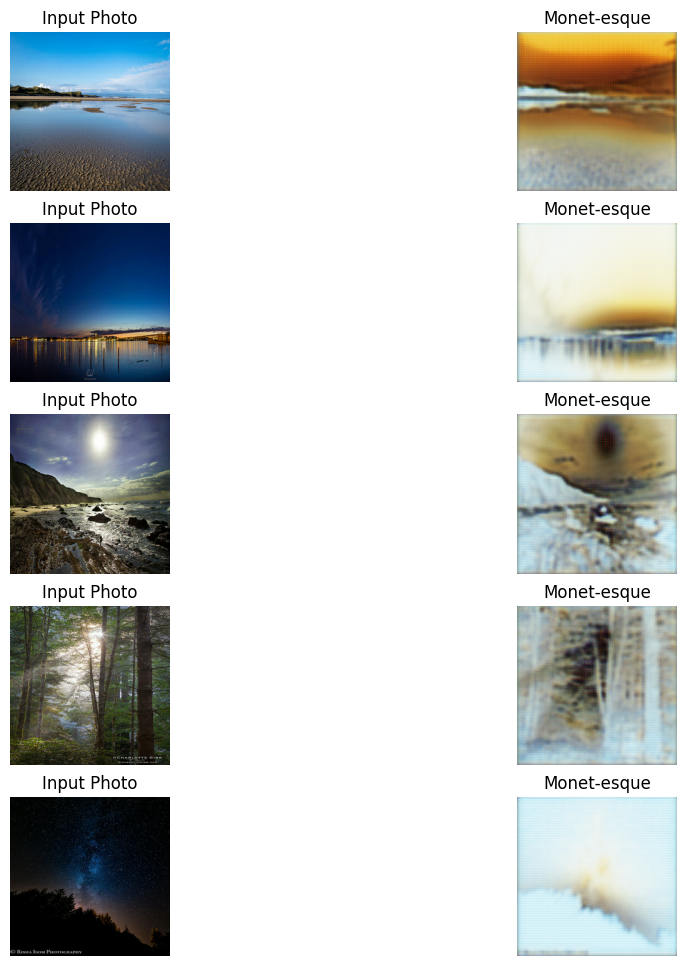

In [19]:
_, ax = plt.subplots(5, 2, figsize=(12, 12))
for i, img in enumerate(photo_ds.take(5)):
    prediction = generator_photo_to_monet(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Monet-esque")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()

# Results from First Model

The model scored 111.956 on the Kaggle public submission. The biggest issue appears to be color consistency across the cycle. Thus, model tuning and hyperparameter tuning will both focus on improving that part of the output.

# Model 2 + Hyperparameters
As noted above, while the model appears to be learning reasonably well, the model does struggle to retain color representation. One reason for this may be the lack of Identity loss. For the next run, I will include identity loss and update the learning rate hyperparameter to account for the increased pass to avoid runtime issues.

In [20]:
LR = 4e-4
generator_photo_to_monet_optimizer = tf.keras.optimizers.Adam(LR, beta_1=0.5)
generator_monet_to_photo_optimizer = tf.keras.optimizers.Adam(LR, beta_1=0.5)
discriminator_monet_optimizer = tf.keras.optimizers.Adam(LR, beta_1=0.5)
discriminator_photo_optimizer = tf.keras.optimizers.Adam(LR, beta_1=0.5)

In [21]:
generator_photo_to_monet = build_generator()
generator_monet_to_photo = build_generator()
discriminator_monet = build_discriminator()
discriminator_photo = build_discriminator()

In [22]:
def identity_loss(real_image, same_image, LAMBDA):
    """
    Calculates the L1 identity loss.

    Encourages the generator to output the input image if the input
    is already from the target domain.
    """
    loss = tf.reduce_mean(tf.abs(real_image - same_image))
    return LAMBDA * 0.5 * loss

In [23]:
LAMBDA = 10
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

@tf.function
def train_step(photo, monet):
    with tf.GradientTape(persistent=True) as tape:
        # Forward cycle: Photo -> Monet -> Photo
        fake_monet = generator_photo_to_monet(photo, training=True)
        cycled_photo = generator_monet_to_photo(fake_monet, training=True)

        # Backward cycle: Monet -> Photo -> Monet
        fake_photo = generator_monet_to_photo(monet, training=True)
        cycled_monet = generator_photo_to_monet(fake_photo, training=True)

        # Feed Monet image to Photo->Monet generator
        same_monet = generator_photo_to_monet(monet, training=True)
        # Feed Photo image to Monet->Photo generator
        same_photo = generator_monet_to_photo(photo, training=True)

        # Discriminator Predictions
        disc_real_monet = discriminator_monet(monet, training=True)
        disc_fake_monet = discriminator_monet(fake_monet, training=True)
        disc_real_photo = discriminator_photo(photo, training=True)
        disc_fake_photo = discriminator_photo(fake_photo, training=True)

        # Calculate Losses
        # Generator adversarial loss
        gen_photo_to_monet_loss = generator_loss(disc_fake_monet)
        gen_monet_to_photo_loss = generator_loss(disc_fake_photo)

        # Cycle consistency loss
        total_cycle_loss = cycle_loss(photo, cycled_photo, LAMBDA) + cycle_loss(monet, cycled_monet, LAMBDA)

        # Identity loss
        id_loss_ptm = identity_loss(monet, same_monet, LAMBDA) # Photo->Monet gen fed Monet
        id_loss_mtp = identity_loss(photo, same_photo, LAMBDA) # Monet->Photo gen fed Photo

        # Total generator losses
        total_gen_ptm_loss = gen_photo_to_monet_loss + total_cycle_loss + id_loss_ptm
        total_gen_mtp_loss = gen_monet_to_photo_loss + total_cycle_loss + id_loss_mtp

        # Discriminator losses
        disc_Monet_loss = discriminator_loss(disc_real_monet, disc_fake_monet)
        disc_Photo_loss = discriminator_loss(disc_real_photo, disc_fake_photo)

    # Calculate the gradients for generators and discriminators
    gradients_gen_ptm = tape.gradient(total_gen_ptm_loss, generator_photo_to_monet.trainable_variables)
    gradients_gen_mtp = tape.gradient(total_gen_mtp_loss, generator_monet_to_photo.trainable_variables)

    gradients_disc_Monet = tape.gradient(disc_Monet_loss, discriminator_monet.trainable_variables)
    gradients_disc_Photo = tape.gradient(disc_Photo_loss, discriminator_photo.trainable_variables)

    # Apply the gradients to the optimizers
    generator_photo_to_monet_optimizer.apply_gradients(zip(gradients_gen_ptm, generator_photo_to_monet.trainable_variables))
    generator_monet_to_photo_optimizer.apply_gradients(zip(gradients_gen_mtp, generator_monet_to_photo.trainable_variables))
    discriminator_monet_optimizer.apply_gradients(zip(gradients_disc_Monet, discriminator_monet.trainable_variables))
    discriminator_photo_optimizer.apply_gradients(zip(gradients_disc_Photo, discriminator_photo.trainable_variables))

In [24]:
EPOCHS = 10

for epoch in range(EPOCHS):
    print(f"Starting epoch {epoch+1}/{EPOCHS}")
    for photo_batch, monet_batch in tf.data.Dataset.zip((photo_ds, monet_ds)):
        train_step(photo_batch, monet_batch)

Starting epoch 1/10
Starting epoch 2/10
Starting epoch 3/10
Starting epoch 4/10
Starting epoch 5/10
Starting epoch 6/10
Starting epoch 7/10
Starting epoch 8/10
Starting epoch 9/10
Starting epoch 10/10


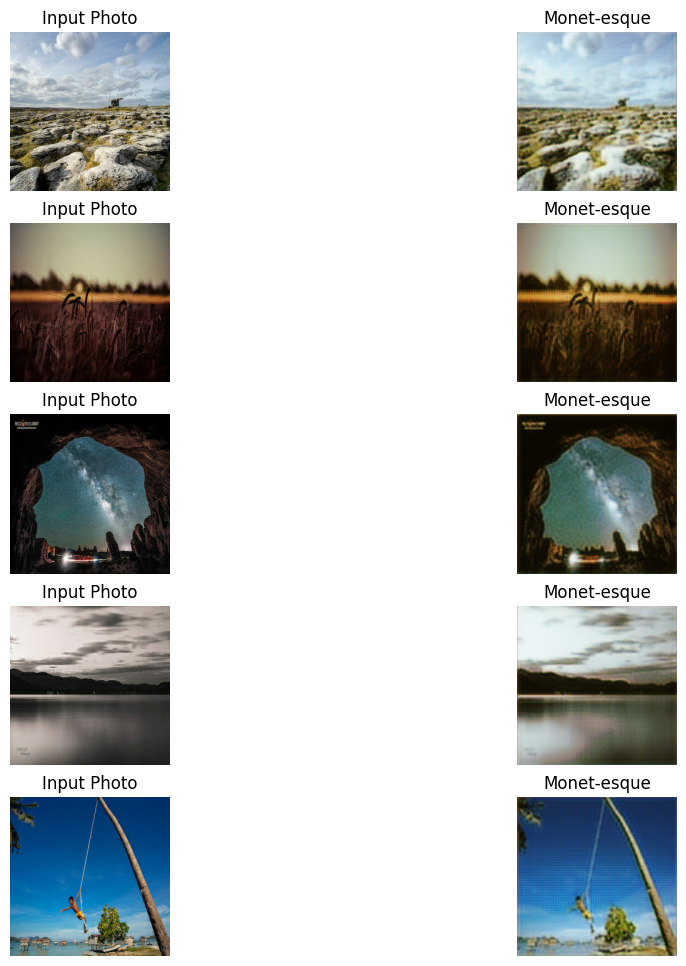

In [25]:
_, ax = plt.subplots(5, 2, figsize=(12, 12))
for i, img in enumerate(photo_ds.take(5)):
    prediction = generator_photo_to_monet(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Monet-esque")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()

| Model    | Kaggle Score |
| -------- | ------- |
| Initial GAN  | 111.956 |
| GAN w/ Identity Loss | 89.747|
|* Note lower score is better

In [26]:
import PIL
! mkdir ../images

In [27]:
i = 1
output_dir = "../images/"
print(f"Starting image generation and saving to {output_dir}...")

for img_batch in photo_ds:
    predictions_batch = generator_photo_to_monet(img_batch, training=False)
    predictions_batch_np = predictions_batch.numpy()
    predictions_batch_rescaled = (predictions_batch_np * 127.5 + 127.5).astype(np.uint8)
    for prediction_img_np in predictions_batch_rescaled:
        im = PIL.Image.fromarray(prediction_img_np)
        filename = os.path.join(output_dir, f"{i}.jpg")
        im.save(filename)
        
        i += 1
print(f"Finished. Saved {i-1} images.")

Starting image generation and saving to ../images/...
Finished. Saved 7038 images.


In [28]:
import shutil
shutil.make_archive("/kaggle/working/images", 'zip', "/kaggle/images")

'/kaggle/working/images.zip'

# Results + Conclusion

The updated model scored 89.747 improving upon the results of the initial model without identity loss. From the visual output, it is clear that adding identity loss helped maintain more of the color characteristics of the input image ultimately improving performance.

**Future Improvements**

GAN networks require multiple passes through the model resulting in relatively long runtimes. With expanded compute, I believe a deeper model with additional residual blocks would improve the generators ability to transform images effectively. Extra runtime allowances would also help improve the total number of epochs allowing for greater flexibility in tuning the learning rate.

Sources:

https://arxiv.org/abs/1703.10593